# Phase Two Final Project Submission

* Student name: Jesse Moore
* Student pace: Flex
* Scheduled project review date/time: ?
* Instructor name: Mark
* Blog post URL:


# Overview
Our clients seek to enter the movie business and we will analyze the profits generated. 

# Data Understanding

### We will analyze datasets from: 

* [Box Office Mojo](https://www.boxofficemojo.com/)
* [IMDB](https://www.imdb.com/)
* [Rotten Tomatoes](https://www.rottentomatoes.com/)
* [TheMovieDB](https://www.themoviedb.org/)
* [The Numbers](https://www.the-numbers.com/)

In our analysis, we will create a new variable, 'total_profit' that will reflect the return on investment for each movie. Then we will find the mean total profit for various groupings of the data, such as by genres, month of release, and the production budget.

### Our first steps will be to load in our different datasets.

In [1]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sqlite3
from zipfile import ZipFile
import os

# Set default plot style to 'fivethirtyeight' for better visuals
plt.style.use('fivethirtyeight')

# Enabling inline plotting for Jupyter Notebooks (useful for displaying graphs directly in the notebook)
%matplotlib inline

In [10]:
#Loading our 'im.db.zip' database'
zip_file_path = 'zippedData/im.db.zip'
extract_folder = 'zippedData/extracted/'

#extracting the database with ZipFile
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [11]:
#Now let's load in our movie gross file
df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')

In [12]:
#Dropping any NA values 
df.dropna(inplace=True)

In [13]:
#now let's import our 'tn.movie_budgets.csv.gz' dataset so that we can analyze the budgets to create a new 'total_profits' feature
new_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', on_bad_lines='skip')

In [15]:
#Now we will create a merged_df with both of our datasets 

# Define the path to the SQLite database file
db_file_path = 'zippedData/extracted/im.db'
# Establish a connection to the SQLite database
conn = sqlite3.connect(db_file_path)

# SQL query to select necessary columns from movie_basics and movie_akas tables
query = '''
    SELECT 
    mb.movie_id,
    mb.primary_title,
    mb.start_year,
    mb.genres,
    ma.title
    FROM movie_basics as mb
    LEFT JOIN
    movie_akas as ma on mb.movie_id = ma.movie_id
'''

# Create a pandas DataFrame by executing the SQL query on the connected database
merged_df = pd.read_sql(query, conn)
#closing our connection to the SQLite database.
conn.close()

## Data Preparation
Now, we must create a merged and clean dataset. This will be a multi-step process involving several datasets and joins. We will create a new feature, 'total_profit' that will reflect the mean total profit for each movie, and new variables 'pop_mean' and 'avg_production_budget' which will reflect the population average profit and the average mean production budget for the entire population. 

In [16]:
#Dropping any rows where our title is duplicated. 
merged_df = merged_df.drop_duplicates(subset='primary_title', keep='first')

In [17]:
#Joining our two datasets to include information such as foreign and domestic gross.
joined_df = pd.merge(df, merged_df, how='inner', left_on='title', right_on='primary_title')

In [18]:
#Joining with our new_df dataframe to now include the production budget.
joined_df2 = pd.merge(joined_df, new_df, how='inner', left_on='title_x', right_on='movie')

In [19]:
#Dropping columns with values that we will not be analyzing as part of this analysis. 
#creating a list of columns that we won't need. 
columns_to_drop = ['studio', 'domestic_gross_x', 'foreign_gross', 'primary_title', 'start_year', 'title_y',
                   'id', 'movie', 'domestic_gross_y']
#dropping the columns. 
joined_df2.drop(columns_to_drop, axis=1, inplace=True)

In [20]:
#Cleaning the 'production_budget' and 'worldwide_gross' columns so that we can create our 'total_profit' variable.
#creating a list of our columns to clean.
columns_to_clean = ['production_budget', 'worldwide_gross']
#cleaning the columns.
joined_df2[columns_to_clean] = joined_df2[columns_to_clean].replace('[/$,]', '', regex=True).astype(float)

In [21]:
#dropping NA columns as they are irrelevant to our purposes today.
joined_df2.dropna(inplace=True)

### Now we must create a 'total_profit' feature to evaluate how much money our movies are actually making. Then we will continue with our data cleaning and grouping. 

In [22]:
#creating our 'total_profit' feature by subtracting our 'production_budget' data from our 'worldwide_gross' data.
joined_df2['total_profit'] = joined_df2['worldwide_gross'] - joined_df2['production_budget']

In [23]:
#Renaming our title_x' column to 'title' for readability and dropping columns unneeded for now. 
joined_df2.rename(columns={'title_x': 'title'}, inplace=True)

In [24]:
#We are going to want to use our 'release_date' column to plot how 'total_profit' has changed, so let's convert that into datetime format.
joined_df2['release_date'] = pd.to_datetime(joined_df2['release_date'])

### We will now create variables that we will use in our plotting, pop_mean, the population mean of 'total_profit', and 'avg_production_budget' which we will also use. 

In [25]:
pop_mean = joined_df2['total_profit'].mean()
avg_production_budget = joined_df2['production_budget'].mean()
print(f'The Average Total Profit for the Population is: {pop_mean}')
print(f'The Mean Production Budget is: {avg_production_budget}')

The Average Total Profit for the Population is: 126794337.95418327
The Mean Production Budget is: 54555988.69521912


In [26]:
#Creating a variable, 'genre_counts', with which we will compare to the average number of genres in our dataset to filter genres with less
#than that amount.
genre_counts = joined_df2.groupby('genres').size()

In [27]:
#Now we will create the 'avg_movies_per_genre' variable to compare 'genre_counts' to.
avg_movies_per_genre = joined_df2['genres'].value_counts().mean()
print(f"Average number of movies per genre: {avg_movies_per_genre:.2f}")

Average number of movies per genre: 5.58


In [28]:
#Now we will determine what genres are 'valid_genres', those which have more than our average number of movies in the dataset. 
valid_genres = genre_counts[genre_counts>= avg_movies_per_genre].index

In [29]:
#Creating the list of the top 10 genres by using groupby to find the mean 'total_profit' of each genre which we will then use to filter our 
#dataset by only the top performing genres that also have more than the average number of movies.
top_genres = joined_df2.groupby('genres')['total_profit'].mean().sort_values(ascending=False).head(10).index

In [30]:
#using intersection() to create the list of valid genres. 
valid_genres_combined = valid_genres.intersection(top_genres)

In [31]:
#Creating our filtered dataset using this information.
filtered_df = joined_df2[joined_df2['genres'].isin(valid_genres_combined)]

In [32]:
#Now using groupby on our dataset to perform the same function as above, the mean 'total_profit' but creating a new dataset. 
grouped_df = filtered_df.groupby('genres')['total_profit'].mean().reset_index()

In [33]:
#Now we can find our 'best_genre' by using sort_values() to sort by 'total_profit' and using 'ascending=False'. 
best_genre = grouped_df.sort_values('total_profit', ascending=False).head(1)

In [34]:
#Extracting the categorical value of what our 'best_genre' actually is. 
best_genre_value = best_genre['genres'].values[0]

In [35]:
best_genre_value

'Action,Adventure,Sci-Fi'

### Now that we know our highest profitting movie genre is 'Action,Adventure,Sci-Fi' we can filter our dataset to only include movies from this genre.

In [36]:
#Now we will create a dataframe with just our best_genre_value, which  happens to be 'Action,Adventure,Sci-Fi'!
best_genre_df = filtered_df[filtered_df['genres'] == best_genre_value]

In [37]:
#Let's group this best_genre_df by year, performing mean and standard deviation aggregate functions on our 'total_profit' columns.
best_genre_by_year_df = best_genre_df.groupby('year')['total_profit'].agg(['mean', 'std']).reset_index()

In [38]:
#creating a pop_mean_by_year_df to compare to our 'best_genre_by_year_df'.
pop_mean_by_year_df = joined_df2.groupby('year')['total_profit'].mean().reset_index()

## Data Modeling

### Now we will create our plot to compare the Mean Gross Profit for Action, Adventure, Sci-Fi movies changes per year, including the standard deviation, as well as a scatter plot of each movie in this genres actual 'total_profit'. We will also add our Population Gross Mean Profit to this visualization to compare our genre to over the years. This allows us to get a very quick glance at how this genre has changed from year to year, as well as the general average total profit for the movies in this genre. 

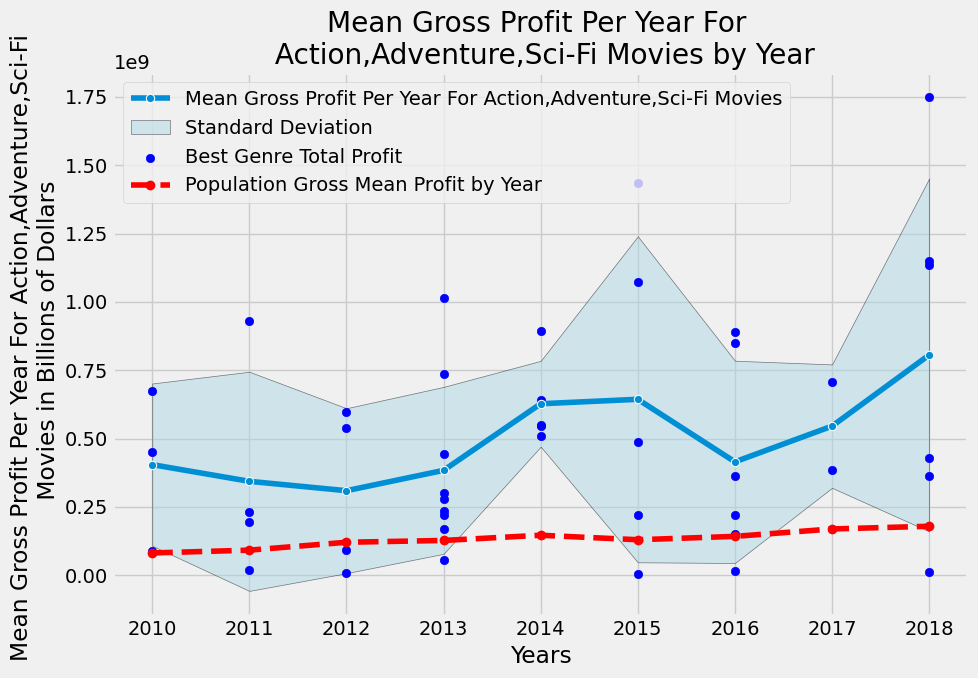

In [39]:
# Set the figure size for the plot
plt.figure(figsize=(10,7))

# Plotting the mean gross profit per year for action, adventure, and sci-fi movies
sns.lineplot(x=best_genre_by_year_df['year'], y=best_genre_by_year_df['mean'], label=f'Mean Gross Profit Per Year For {best_genre_value} Movies', marker='o')

# Adding a shaded area to represent the standard deviation around the mean
plt.fill_between(best_genre_by_year_df['year'], best_genre_by_year_df['mean'] - best_genre_by_year_df['std'], 
                 best_genre_by_year_df['mean'] + best_genre_by_year_df['std'], color="lightblue", edgecolor='black', alpha=0.5, label='Standard Deviation')

# Plotting scatter points for the 'best_genre_df' dataset, representing total profit.
plt.scatter(best_genre_df['year'], best_genre_df['total_profit'], marker='o', color='blue', label='Best Genre Total Profit')

# Plotting the population mean gross profit per year (from 'pop_mean_by_year' dataset)
plt.plot(pop_mean_by_year_df['year'], pop_mean_by_year_df['total_profit'], linestyle = '--', color = 'r', label='Population Gross Mean Profit by Year', marker='o')

# Adding labels and title to the plot
plt.xlabel('Years')
plt.ylabel(f'Mean Gross Profit Per Year For {best_genre_value} \n Movies in Billions of Dollars')
plt.title(f'Mean Gross Profit Per Year For \n {best_genre_value} Movies by Year')

# Adding the legend to distinguish different lines and points
plt.legend()

# Adjusting the layout to ensure everything fits without overlap
plt.tight_layout()

# Saving the plot as a PNG image
plt.savefig('Mean_Total_Profit_By_Year.png');

## 1. Investing in High-Performing Movie Genres:

The analysis indicates that the Action, Adventure, Sci-Fi genre has consistently outperformed the overall movie market in terms of average total profit over the past three years. Notably, this genre’s profits have increased by over a quarter of a billion dollars during this period. Given this consistent growth trend, we recommend that stakeholders consider allocating resources to the Action, Adventure, Sci-Fi genre as a strategic focus for future investments. This genre shows strong potential for continued profitability.

### Now we will create a linear regression plot of 'total_profit' by 'production_budget' for our 'Action,Adventure,Sci-Fi' movies and include the avg_production_budget and the pop_mean, so that we can get further perspective on how this genre performs in comparison to other genres, as well as what role production budget will play in our profits. 

In [40]:
#Creating our model. 
model = sm.OLS(endog=best_genre_df['production_budget'], exog=sm.add_constant(best_genre_df['total_profit']))

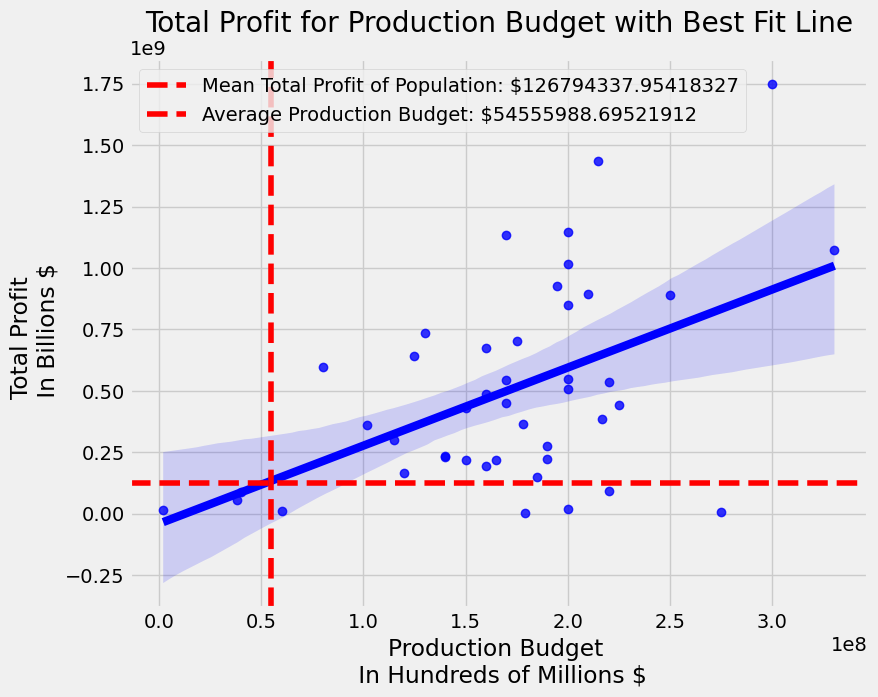

In [41]:
# Set the figure size
plt.figure(figsize=(9,7))

# Create a regression plot (scatter + regression line) for production budget vs total profit
sns.regplot(x=best_genre_df['production_budget'], y=best_genre_df['total_profit'], data=best_genre_df, color='blue')

# Create a regression plot (scatter + regression line) for production budget vs total profit
plt.title('Total Profit for Production Budget with Best Fit Line')
plt.xlabel('Production Budget \n In Hundreds of Millions $')
plt.ylabel('Total Profit \n In Billions $')

# Add a horizontal line for the population mean
plt.axhline(pop_mean, color='r', linestyle = '--', label=f'Mean Total Profit of Population: ${pop_mean}')

# Add a vertical line for the average production budget
plt.axvline(avg_production_budget, color='r', linestyle = '--', label=f'Average Production Budget: ${avg_production_budget}')

# Adjust the layout to ensure everything fits without overlap
plt.tight_layout()

# Add the legend to the plot
plt.legend()

# Save the plot as a PNG file
plt.savefig('Total_Profit_for_Production_Budget.png');

In [42]:
#Fitting the model. 
results = model.fit()

In [43]:
#printing our F stat and our F P-value.
print(f'F Value: {results.fvalue}, F P-Value: {results.f_pvalue}')

F Value: 14.217282301713881, F P-Value: 0.0005031563425691874


In [44]:
'''17.14 indicates that the independent variables (e.g., production budget, genre) explain a substantial portion of
the variance in the dependent variable (e.g., total profit).
The p-value of 0.000154 is so small that it provides very strong evidence that the relationship between the independent
variables and total profit is not due to random chance. Therefore, you can confidently reject the null hypothesis and conclude
that the independent variable(s) have a significant impact on the dependent variable.

The F-value of 17.14 indicates that your model fits the data well.
The F P-value of 0.000154 tells you that the relationship is statistically significant, and you can conclude that there is a 
meaningful relationship between the independent variable(s) and the dependent variable (e.g., production budget and total profit).'''

'17.14 indicates that the independent variables (e.g., production budget, genre) explain a substantial portion of\nthe variance in the dependent variable (e.g., total profit).\nThe p-value of 0.000154 is so small that it provides very strong evidence that the relationship between the independent\nvariables and total profit is not due to random chance. Therefore, you can confidently reject the null hypothesis and conclude\nthat the independent variable(s) have a significant impact on the dependent variable.\n\nThe F-value of 17.14 indicates that your model fits the data well.\nThe F P-value of 0.000154 tells you that the relationship is statistically significant, and you can conclude that there is a \nmeaningful relationship between the independent variable(s) and the dependent variable (e.g., production budget and total profit).'

## 2. Optimizing Investment for Maximum Returns 
Our analysis reveals a statistically significant positive correlation between production investment and movie profits. This suggests that increased investment directly leads to higher returns. Therefore, to maximize profitability, we advise the production company to increase their investment in future projects. While this may seem intuitive, the data substantiates that larger financial commitments yield a measurable and reliable boost in profit generation.

### Now let's create a 'month_order' feature so that we can order our dataframe each month, to see if there are months that would be statistically more profitable than others. We don't want our client releasing a movie in a month where people do not attend the movies as frequently!

In [45]:
#Creating a list to use of month orders. 
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

#copying our dataframe to avoid errors.
best_genre_df = best_genre_df.copy()
#Creating our 'release_month' feature.
best_genre_df.loc[: ,'release_month'] = best_genre_df['release_date'].dt.strftime('%B')

#creating our 'month_order' feature with numerical values corresponding to our month_order list to then sort our dataframe by months. 
best_genre_df.loc[:, 'month_order'] =  best_genre_df['release_month'].map({month: i for i, month in enumerate(month_order)})

In [46]:
#Now we can use groupby() to find the mean profits by month and plot them. 
grouped_by_month_df = best_genre_df.groupby(['release_month', 'month_order'])['total_profit'].mean().reset_index()

In [47]:
#Sorting our dataframe by 'month_order'
grouped_by_month_df.sort_values('month_order', inplace=True)

### Now let's create a chart that shows how release dates can effect the total_profit of a movie.

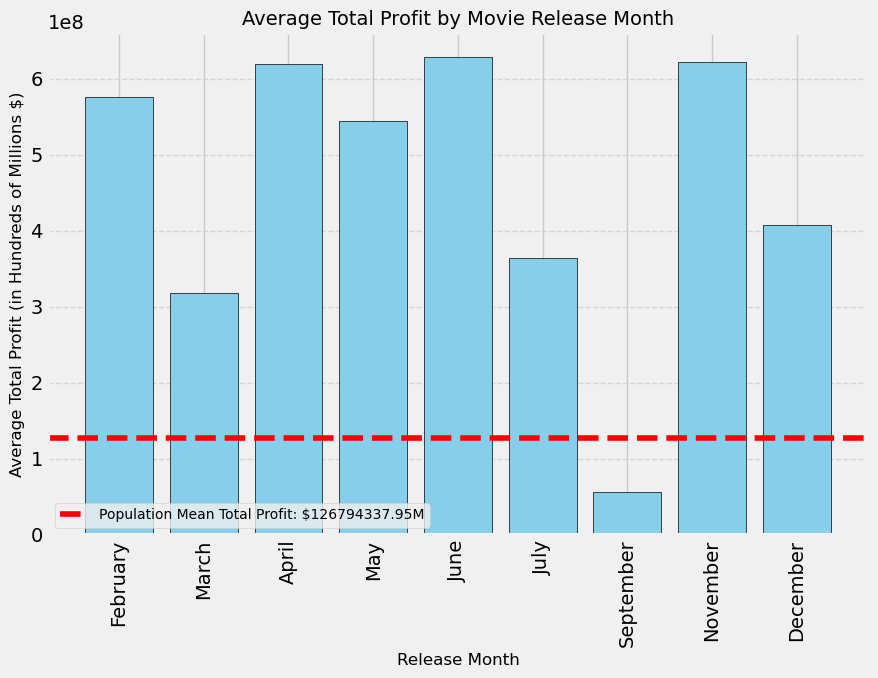

In [48]:
# Create the bar plot
plt.figure(figsize=(9,7))
plt.bar(data=grouped_by_month_df, x=grouped_by_month_df['release_month'], height=grouped_by_month_df['total_profit'], color='skyblue', 
       edgecolor='black')

# Add a horizontal line for the population mean
plt.axhline(pop_mean, color='r', linestyle = '--', label=f'Population Mean Total Profit: ${pop_mean:.2f}M')

# Adding labels to the axes
plt.xlabel('Release Month', fontsize=12)
plt.ylabel('Average Total Profit (in Hundreds of Millions $)', fontsize=12)

# Adding a title
plt.title('Average Total Profit by Movie Release Month', fontsize=14)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Adding gridlines for better readability of the y-axis values
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding the legend
plt.legend(loc='lower left', fontsize=10)

# Adjust the layout to ensure everything fits without overlap
plt.tight_layout()

# Save the plot as a PNG image and using ';' to show the plot. 
plt.savefig('Average_Total_Profit_by_Movie_Release_Month.png');

In [49]:
#Now we will print our top three most profitable on average months. 
grouped_by_month_df.sort_values('total_profit', ascending=False).head(3)

,release_month,month_order,total_profit
4,June,5,6.283848e+08
7,November,10,6.218100e+08
0,April,3,6.189100e+08


In [50]:
grouped_by_month_df.sort_values('total_profit', ascending=False).tail(3)

,release_month,month_order,total_profit
3,July,6,3.637059e+08
5,March,2,3.176831e+08
8,September,8,5.676376e+07


## 3. Timing the Release for Maximum Profitability
The analysis of monthly performance trends shows that June, November, and April are the highest-performing months for movie releases, with average profits significantly exceeding those of other months. Conversely, September is identified as the lowest-performing month, followed by March and July. To capitalize on peak profitability, we recommend scheduling movie releases during the months of June, November, or April, while avoiding September and other underperforming months.

## Conclusion

## Business Recommendations

Based on the analysis, I would recommend the business:

Focus on high-performing genres: Given that the Action, Adventure, Sci-Fi genre has demonstrated strong and consistent profitability, the company should consider prioritizing investments in these genres when planning future film productions. This targeted approach can maximize the likelihood of financial success.

Optimize production budgets: Since data indicates a direct correlation between increased investment and higher profits, the company should consider allocating larger budgets to future films. However, this should be done strategically to ensure that investment is maximized without overspending.

Time film releases strategically: The analysis suggests that certain months (e.g., June, November, and April) are more profitable for movie releases than others. Therefore, the company should schedule movie premieres during these peak months to capitalize on higher audience engagement and better box office performance.

### Why Might Our Analysis Not Fully Address the Problem?

External market factors: The analysis does not account for potential external factors that could impact movie success, such as economic conditions, competition from other studios, or changing consumer tastes. These factors could significantly influence box office performance and should be considered in future analyses.

Assumption of historical trends: The analysis is based on historical data, which assumes that past trends will continue. However, the entertainment industry is dynamic, and market conditions, consumer preferences, and industry trends can change rapidly. The insights gained may only be applicable to the current context and may not fully predict future performance.

Overreliance on profit as a metric: Profit is an important indicator, but it does not capture the full picture. Other factors, such as audience satisfaction, critical reception, or brand-building for the studio, could be equally important in determining the long-term success of a movie studio.

### 3. What else could you do in the future to improve this project?

To improve the analysis and make it more comprehensive in the future, consider the following:

Incorporate additional data: Gathering more detailed data on factors like social media engagement could provide deeper insights into what drives success. 

Track evolving trends over time: The business should regularly update its analysis to track shifts in movie-goer preferences, genre popularity, and market conditions. This would allow the company to adjust its strategies dynamically rather than relying on static insights.